# Spatial Correlations of bacterial suspensions

Here we use spatial correlaitons (orientation, velocity and pixel intensity) to identify the transition from disordered phase to ordered phase. 

We also compare the concentration dependence of correlation length with that of GNF scaling exponent $\alpha$.

## 1. Packages and presets

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure
import pandas as pd
from scipy.signal import savgol_filter, medfilt
import os
import corrLib
from scipy.signal import savgol_filter
import matplotlib as mpl
from numpy.polynomial.polynomial import polyvander
from scipy.optimize import curve_fit
from miscLib import label_slope
from corrLib import density_fluctuation
from scipy import signal
from scipy.interpolate import griddata
import matplotlib
import pandas as pd

In [2]:
# figure initializing presets
presets = {}
presets['1-column-2-panel'] = (1.25, 1.57, 157)
presets['1-column-1-panel'] = (1.25, 3.2, 157)
h, w, dpi = presets['1-column-2-panel']

In [3]:
# matplotlib configs

# FONT
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['text.usetex'] = True 

# FIGURE
matplotlib.rcParams['figure.figsize'] = w, h
matplotlib.rcParams['figure.dpi'] = dpi

# AXES
matplotlib.rcParams['axes.labelpad'] = 1.0
matplotlib.rcParams['axes.labelsize'] = 'small'
matplotlib.rcParams['axes.linewidth'] = 0.5

# TICKS
matplotlib.rcParams['xtick.labelsize'] = 'small'
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.major.size'] = 2.5
matplotlib.rcParams['xtick.minor.size'] = 1.6

matplotlib.rcParams['ytick.labelsize'] = 'small'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.major.size'] = 2.5
matplotlib.rcParams['ytick.minor.size'] = 1.6

# LEGEND
matplotlib.rcParams['legend.labelspacing'] = 0.2
matplotlib.rcParams['legend.handlelength'] = 1
matplotlib.rcParams['legend.fontsize'] = 'small'
matplotlib.rcParams['legend.handletextpad'] = 0.2
matplotlib.rcParams['legend.columnspacing'] = 0.5
matplotlib.rcParams['legend.frameon'] = False

## 2. intensity, orientation and velocity spatial correlation

### 2.1 Intensity correlation

Correlation data is a dataframe with columns (R, C, conc). 

**Fit data with exponential**

The correlation functions are all identified as exponential decay. In order to determine the length scale of the correlation function, I need to fit the functions with exponential $$y = be^{-ax}$$

In [80]:
def exp(x, a, b):
    return b * np.exp(-a*x)

In [134]:
def corr_length(data, fitting_range=None):
    """
    Args:
    data -- dataframe with columns (R, C), where R has pixel as unit
    fitting_range -- (optional) can be None, int or list of two int
    
    Returns:
    cl -- correlation length of given data (pixel)
    """
    if fitting_range == None:
        pass
    elif isinstance(fitting_range, int):
        data = data.loc[data['R'] < fitting_range]
    elif isinstance(fitting_range, list) and len(fitting_range) == 2:
        data = data.loc[(data['R'] < fitting_range[1])&(data['R'] >= fitting_range[0])]
    else:
        raise ValueError('fitting_range should be None, int or list of 2 int')
        
    fit = curve_fit(exp, data['R'], data['C'], p0=[0.01, 1])
    cl = 1 / fit[0][0]
    return cl, fit

In [145]:
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
clI = []
ranges = [30, 30, 100, 100, 100]
for nt, r in zip(data.conc.drop_duplicates(), ranges):
    subdata = data.loc[data.conc==nt]
    cl, fit = corr_length(subdata, fitting_range=r)
    clI.append(cl)

<font color='red'><b>Comment to myself:</b></font> The correlation-distance plot (the cell below) is not working because of the polynomial fitting. Replacing the fitting with exponential can fix the issue. Will implement when I have time.

LinAlgError: SVD did not converge in Linear Least Squares

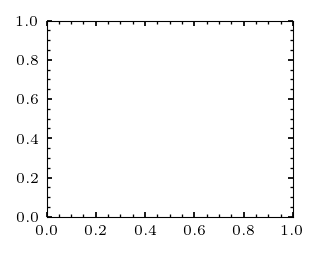

In [164]:
deg = 20 # degree of polynomial fitting
sparcity = 4 # how sparce the data lines are, larger value means less points
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
mpp = 0.33
count = 0
lb = 3 # um

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    x = subdata.R
    y = subdata.C
    p = np.polyfit(x, y, deg)
    xfit = np.linspace(0, x.max(), int(x.max()/sparcity))
    yfit = np.dot(polyvander(xfit, deg), np.flip(p).transpose())
    ax.plot(xfit*mpp/lb, yfit, color=wowcolor(count), label=str(nt), ls='',
            marker='o', markersize=2)
    count += 1
ax.legend()
# plt.axis([0, 133, -0.2, 1.1])
ax.set_xlabel('$l/l_b$')
ax.set_ylabel('$C_{I}$')

### 2.2 Orientation correlation

**Combine seperate (R, C) data sheets into one (R, C, conc) data sheet**

I originally saved $C_A$ and $C_V$ data at different concentrations in different files since save in one file requires recording duplicated concentration information. But this archetecture results in many files and information in file names which is even harder to manage and subject to accidental change. Thus here I combine them back into one file.

<font color='red'><b>Comment to myself:</b></font> in the future, this data can be saved in better structure, such as h5 files. Explore!

In [108]:
folder = r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr'
l = dirrec(folder, 'CA*')
for num, d in enumerate(l):
    subdata = pd.read_csv(d)
    f, ne = os.path.split(d)
    n = ne.split('.')[0]
    conc = int(n[2:])
    if num == 0:
        data = subdata.assign(conc=conc)
    else:
        data = data.append(subdata.assign(conc=conc))

In [111]:
data.to_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorrA.csv', index=False)

In [112]:
folder = r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr'
l = dirrec(folder, 'CV*')
for num, d in enumerate(l):
    subdata = pd.read_csv(d)
    f, ne = os.path.split(d)
    n = ne.split('.')[0]
    conc = int(n[2:])
    if num == 0:
        data = subdata.assign(conc=conc)
    else:
        data = data.append(subdata.assign(conc=conc))

In [114]:
data.to_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorrV.csv', index=False)

**Compute correlation lengths of orientation and velocity**

In [151]:
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorrA.csv')
clA = []
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    cl, fit = corr_length(subdata, fitting_range=1000)
    clA.append(cl)

In [154]:
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorrV.csv')
clV = []
for nt in data.conc.drop_duplicates():
    subdata = data.loc[data.conc==nt]
    cl, fit = corr_length(subdata, fitting_range=1000)
    clV.append(cl)

**Plot correlation lengths together**

Text(0, 0.5, '$l_c/l_b$')

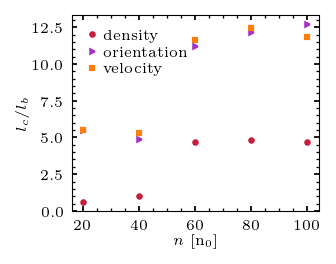

In [156]:
lb = 3
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])    
n = [20, 40, 60, 80, 100]
ax.plot(n, np.array(clI)*mpp/lb, ls='', marker='o', color=wowcolor(0),
        markersize=2)
ax.plot(n, np.array(clA)*mpp/lb, ls='', marker='>', color=wowcolor(1),
        markersize=2)
ax.plot(n, np.array(clV)*mpp/lb, ls='', marker='s', color=wowcolor(2),
        markersize=2)
ax.legend(['density', 'orientation', 'velocity'], loc='upper left')
ax.set_xlabel('$n$ [n$_0$]')
ax.set_ylabel('$l_c/l_b$')

## 3. Compare spatial correlations and GNF

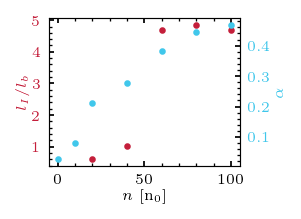

In [163]:
mpp = 0.33
lb = 3 # um
data = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig3-spatialCorr\spatialCorr_crop.csv')
cs = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig2-GNF\conc-slope.csv')
n = [20, 40, 60, 80, 100]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

color = wowcolor(0)
ax1.plot(np.array(n), np.array(clI)*mpp/lb, ls='', marker='o', color=color,
        markersize=2, lw='2')
ax1.set_xlabel('$n$ [n$_0$]')
ax1.set_ylabel('$l_I/l_b$', color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = wowcolor(4)
ax2.plot(cs.conc, cs.slope, ls='', marker='o', color=color,
        markersize=2, lw='2')
ax2.set_ylabel('$\\alpha$', color=color)
ax2.tick_params(axis='y', labelcolor=color)